In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### EXPLORATORY DATA ANALYSIS

In [3]:
raw_data = pd.read_csv("/Users/lilitharutyunyan/Documents/GitHub/compas-analysis/compas-scores-two-years.csv", parse_dates=["c_jail_in", "c_jail_out"])
raw_data.shape

(7214, 53)

In [4]:

df = raw_data[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
          "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]





In [5]:
df = df[
        (df["days_b_screening_arrest"]<=30) & 
        (df["days_b_screening_arrest"]>=-30) &
        (df["is_recid"]!=-1) & 
        (df["c_charge_degree"]!="O") #&
        #(dataframe["score_text"]!="N/A")
      ]

In [6]:
df.shape

(6172, 13)

In [7]:
category_cols = ['c_charge_degree', "race", "age_cat", 'score_text', 'sex', 'is_recid', 'two_year_recid']
df = df.apply(lambda s: s.astype('category') if s.name in category_cols else s)

### Demographic breakdown

* Higher COMPAS scores are slightly correlated with a longer length of stay

In [8]:
df["length_of_stay_days"] = (df.c_jail_out-df.c_jail_in).dt.days
np.round(df[["length_of_stay_days", "decile_score"]].corr()\
        .loc["length_of_stay_days","decile_score"],5)

#The loc() function helps us to retrieve data values from a dataset at an ease. Using the loc() function, 
#we can access the data values fitted in the particular row or column based on the index value passed to the function.


0.20748

In [9]:
np.corrcoef(df['length_of_stay_days'],df['decile_score'])

array([[1.        , 0.20747808],
       [0.20747808, 1.        ]])

* After filtering we have the following demographic breakdown:

In [10]:
df.age_cat.value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [11]:
df.race.value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [12]:
(df.race.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

# With normalize set to True , returns the relative frequency by dividing all values by the sum of values.

African-American    51.44%
Caucasian           34.07%
Hispanic             8.25%
Other                5.56%
Asian                0.50%
Native American      0.18%
Name: race, dtype: object

In [13]:
df.score_text.value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [14]:
pd.crosstab(df["sex"],df["race"])


race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [15]:
df.sex.value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [16]:
(df.sex.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

Male      80.96%
Female    19.04%
Name: sex, dtype: object

In [19]:
no_recid = np.sum(df['two_year_recid'] ==1)
print ('# of entries with two_ear_recid:', no_recid)
print ('% of entries with two_ear_recid:', np.round(no_recid/df.shape[0]*100,2))

# of entries with two_ear_recid: 2809
% of entries with two_ear_recid: 45.51


* Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.



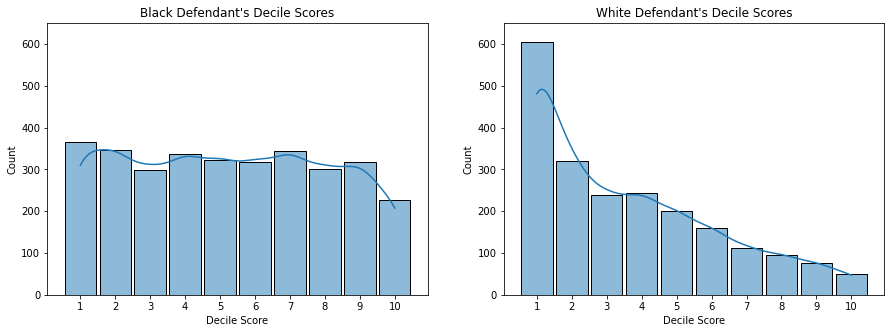

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
plt.setp(axes, ylim=(0,650), xticks=np.arange(1,11), xlabel="Decile Score")

scores_black = df[df["race"]=="African-American"]["decile_score"]
scores_white = df[df["race"]=="Caucasian"]["decile_score"]

sns.histplot(
    x=scores_black,
    bins=10, 
    ax=axes[0], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[0].set_title("Black Defendant's Decile Scores")

sns.histplot(
    x=scores_white,
    bins=10, 
    ax=axes[1], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[1].set_title("White Defendant's Decile Scores");

In [21]:
pd.crosstab(df["decile_score"],df["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


### Racial Bias in Compas
* After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.